In [1]:
# First, make sure to install required packages
# !pip install ultralytics opencv-python matplotlib pillow easyocr pandas

from ultralytics import YOLO
import cv2
from pathlib import Path
import numpy as np
from collections import Counter
import threading
import queue
from time import time, sleep
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import io
import easyocr
import pandas as pd
import csv
import os

# Input options
MODEL_PATH = "runs/detect/train6/weights/best.pt"
INPUT_VIDEO_FPS = 60
EXTRA_CAMERA_DELAY = 1  # Delay in seconds
MAX_FRAMES = 10068 # The amount of frames to process before quitting

# Algorithm options
IMAGE_SIZE = 160
BATCH_SIZE = 100
SKIP_FRAMES = 8 # Skip this many frames between each processing step
TEMPORAL_CUTOFF_THRESHOLD = 15  # Amount of frames a bottle needs to be seen to be considered tracked.
BOTTLE_DISAGREEMENT_TOLERANCE = 30  # Amount of frames the cameras can disagree before correction is applied.
SEQUENTIAL_CORRECTION_THRESHOLD = 3 # If a tracker has to be corrected this many times in a row, it's permanently steered back on track.
ENFORCE_INCREMENTAL_CORRECTION = False # Make sure the corrected index is unique.
EXTRA_CORRECTION = False # Allow correcting half the feed if one half disagrees with itself.

# Preview options
PREVIEW_IMAGE_SIZE = 640
SAVE_VIDEO = True
EASE_DISPLAY_SPEED = True
DISPLAY_FRAMERATE = 30
MAX_QUEUE_SIZE = 1000 # The limit for the queue size, set to -1 to disable limit (but beware you might run out of memory then!)
QUEUE_SIZE_CHECK_INTERVAL = 1 # Amount of seconds to wait when queue is full
RENDER_SKIPPED_FRAMES = True
SKIPPED_IMAGE_SIZE = 200

# OCR options
USE_OCR = True
OCR_CONFIDENCE_THRESHOLD = 0.5
OCR_READER = None
OCR_RESULTS_CSV = "bottle_ocr_results.csv"
OCR_FRAME_INTERVAL = 2  # Process OCR every N frames for each bottle
OCR_MAX_ATTEMPTS_PER_BOTTLE = 50  # Maximum number of OCR attempts per bottle (to prevent infinite processing)

# Logging options
VERBOSE_YOLO = False # Show YOLO debug info
VERBOSE_LOGS = True # Show general info
VERBOSE_BLAB = False # Show detailed debug info
VERBOSE_DBUG = True # Show debug info

def log(*values: object, **kwargs):
    if not VERBOSE_LOGS: return
    print(*values, **kwargs)
    
def blabber(*values: object, **kwargs):
    if not VERBOSE_BLAB: return
    print(*values, **kwargs)

def initialize_ocr():
    """Initialize the OCR reader"""
    if not USE_OCR:
        return None
    try:
        log("Initializing EasyOCR...")
        # Initialize EasyOCR reader
        reader = easyocr.Reader(['en'])  # English language
        log("EasyOCR initialized successfully")
        return reader
    except Exception as e:
        log(f"Error initializing OCR: {e}")
        return None

def save_ocr_to_csv(bottle_id, camera_name, frame_number, ocr_text, confidence, timestamp):
    """Save OCR results to CSV file"""
    csv_file = OCR_RESULTS_CSV
    
    # Create dataframe with new entry
    new_entry = {
        'bottle_id': bottle_id,
        'camera_name': camera_name,
        'frame_number': frame_number,
        'ocr_text': ocr_text,
        'confidence': confidence,
        'timestamp': timestamp,
        'processing_time': time()
    }
    
    # Check if file exists to determine if we need to write header
    file_exists = os.path.isfile(csv_file)
    
    try:
        with open(csv_file, 'a', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=new_entry.keys())
            if not file_exists:
                writer.writeheader()
            writer.writerow(new_entry)
    except Exception as e:
        log(f"Error writing to CSV: {e}")

def extract_text_from_roi(reader, frame, x1, y1, x2, y2):
    """Extract text from a region of interest"""
    if reader is None:
        return "", 0.0
    
    try:
        # Extract ROI from frame
        roi = frame[y1:y2, x1:x2]
        
        if roi.size == 0:
            return "", 0.0
        
        # Perform OCR on the ROI
        results = reader.readtext(roi)
        
        if not results:
            return "", 0.0
        
        # Combine all detected text with confidence scores
        combined_text = ""
        total_confidence = 0.0
        valid_results = 0
        
        for (bbox, text, confidence) in results:
            if confidence >= OCR_CONFIDENCE_THRESHOLD:
                combined_text += text + " "
                total_confidence += confidence
                valid_results += 1
        
        if valid_results > 0:
            avg_confidence = total_confidence / valid_results
            return combined_text.strip(), avg_confidence
        else:
            return "", 0.0
            
    except Exception as e:
        log(f"OCR extraction error: {e}")
        return "", 0.0

class Bottle:
    index: int = -1
    x: float
    y: float
    in_view: bool = True
    yolo_id: int
    was_corrected: bool = False
    ocr_texts: list = None  # Store multiple OCR results
    best_ocr_text: str = ""
    best_ocr_confidence: float = 0.0
    ocr_attempts: int = 0
    last_ocr_frame: int = -1
    
    def __init__(self, x: float, y: float, yolo_id: int):
        self.x = x
        self.y = y
        self.yolo_id = yolo_id
        self.ocr_texts = []  # Initialize as empty list
    
    def add_ocr_result(self, text, confidence, frame_number):
        """Add OCR result and track the best one"""
        self.ocr_attempts += 1
        self.last_ocr_frame = frame_number
        
        # Store all OCR results
        self.ocr_texts.append({
            'text': text,
            'confidence': confidence,
            'frame_number': frame_number,
            'timestamp': time()
        })
        
        # Update best result if this is better
        if confidence > self.best_ocr_confidence:
            self.best_ocr_text = text
            self.best_ocr_confidence = confidence
            
    def should_process_ocr(self, current_frame):
        """Determine if we should process OCR for this bottle in the current frame"""
        if self.ocr_attempts >= OCR_MAX_ATTEMPTS_PER_BOTTLE:
            return False
        
        # Process OCR at regular intervals
        if self.last_ocr_frame == -1 or (current_frame - self.last_ocr_frame) >= OCR_FRAME_INTERVAL:
            return True
        
        return False

class Camera:
    name: str
    video_path: str
    output_path: str
    cap: cv2.VideoCapture
    out: cv2.VideoWriter
    width: int
    height: int
    adjusted_width: int
    adjusted_height: int
    aspect_ratio: float
    processed_frame_count: int = 0
    model: YOLO
    temporary_bottles: dict[int, Bottle] = {}
    bottles: dict[int, Bottle]
    track_ids_seen: dict[int, int] = {}  # Count of frames each track ID has been seen in
    bottle_index_counter: int = 0
    # start_delay: float = 0 # seconds
    capture_fps: float
    frames_since_last_registration: int = 0
    last_registered_bottle: Bottle = None
    last_registered_bottle_track_id: int = -1
    sequential_correction_count: int = 0
    ocr_reader: easyocr.Reader
    
    # frames: list[cv2.typing.MatLike]
    # result_queue: list
    frame_index: int
    # last_results = None
    
    def get_allowed_frame_skip(self):
        return SKIP_FRAMES if SKIP_FRAMES > 0 else 1
    
    def skip_frames(self, frames_to_skip: int, collect_skipped: bool = False):
        frames = []
        if frames_to_skip > 0:
            for _ in range(frames_to_skip):
                ret, frame = self.cap.read()
                if not ret:
                    return frames
                if collect_skipped:
                    output_frame_width = int(SKIPPED_IMAGE_SIZE * self.aspect_ratio)
                    output_frame_height = SKIPPED_IMAGE_SIZE
                    output_frame = cv2.resize(frame, (output_frame_width, output_frame_height))
                    frames.append(output_frame)
        return frames
    
    def __init__(self, name: str, video_path: str, start_delay: int = 0, start_index: int = 0):
        self.name = name
        self.video_path = video_path
        input_path = Path(video_path)
        
        self.cap = cv2.VideoCapture(video_path)
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.capture_fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.last_results = None
        
        self.aspect_ratio = self.width / self.height
        self.adjusted_width = int(IMAGE_SIZE * self.aspect_ratio)
        self.adjusted_height = IMAGE_SIZE
        
        # Calculate the output video dimensions (same as display size)
        self.output_width = int(PREVIEW_IMAGE_SIZE * self.aspect_ratio)
        self.output_height = PREVIEW_IMAGE_SIZE
        
        # Initialize OCR reader for this camera
        self.ocr_reader = OCR_READER
        
        if SAVE_VIDEO:
            self.output_path = f'runs/detect/track/{input_path.stem}_tracked.mp4'
            # Create the output directory if it doesn't exist
            Path(self.output_path).parent.mkdir(parents=True, exist_ok=True)
            
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            # Use the output dimensions (display size) for the video writer
            self.out = cv2.VideoWriter(
                self.output_path, 
                fourcc, 
                self.capture_fps / self.get_allowed_frame_skip(), 
                (self.output_width, self.output_height)
            )
            log(f"Camera {self.name}: Saving video to {self.output_path} with dimensions {self.output_width}x{self.output_height}")
        
        self.bottles = {}
        self.bottle_index_counter = start_index
        
        start_delay += EXTRA_CAMERA_DELAY
        frames_to_skip = int(start_delay * self.capture_fps)
        log(f"Camera {self.name}: Skipping first {frames_to_skip} frames for start delay of {start_delay} seconds.")
        self.skip_frames(frames_to_skip)
        
        self.processed_frame_count = 0
        
        blabber("Finished camera setup. Loading model...")
        self.model = YOLO(MODEL_PATH)
        blabber("Finished loading model!")
        
        self.results_queue = queue.Queue()
        self.frame_queue: queue.Queue = queue.Queue()
        self.frame_index = 0
        self.running = False
        self.producer_thread = None
        self.last_output_frame: np.ndarray = None
        
    def get_frame(self):
        try:
            frame = self.frame_queue.get()
            results = self.results_queue.get()
            # log(f"Camera {self.name}: Retrieved frame {self.frame_queue.qsize()} items remaining.")
            return frame, results
        except queue.Empty:
            return None, None
    
    def perform_ocr_on_bottle(self, frame, bottle, x1, y1, x2, y2):
        """Perform OCR on a bottle region and update bottle object"""
        if not USE_OCR or self.ocr_reader is None:
            return
        
        # Check if we should process OCR for this bottle in this frame
        if not bottle.should_process_ocr(self.processed_frame_count):
            return
        
        # Expand ROI slightly to capture more context
        expansion = 10
        x1_exp = max(0, x1 - expansion)
        y1_exp = max(0, y1 - expansion)
        x2_exp = min(frame.shape[1], x2 + expansion)
        y2_exp = min(frame.shape[0], y2 + expansion)
        
        ocr_text, confidence = extract_text_from_roi(self.ocr_reader, frame, x1_exp, y1_exp, x2_exp, y2_exp)
        
        # Always add OCR result if we found something (even low confidence)
        if ocr_text:  # Only add if we actually found text
            bottle.add_ocr_result(ocr_text, confidence, self.processed_frame_count)
            
            # Save resutls to CSV if we have meaningful text with reasonable confidence
            if confidence >= OCR_CONFIDENCE_THRESHOLD:
                save_ocr_to_csv(
                    bottle_id=bottle.index,
                    camera_name=self.name,
                    frame_number=self.processed_frame_count,
                    ocr_text=ocr_text,
                    confidence=confidence,
                    timestamp=time()
                )
                if VERBOSE_DBUG:
                    log(f"Camera {self.name}: Bottle {bottle.index} OCR [{bottle.ocr_attempts}]: '{ocr_text}' (confidence: {confidence:.2f})")
    
    def render_frame(self):
        frame, results = self.get_frame()
        if frame is None or results is None:
            return None
        
        output_frame_width = int(PREVIEW_IMAGE_SIZE * self.aspect_ratio)
        output_frame_height = PREVIEW_IMAGE_SIZE
        
        frame = cv2.resize(frame, (output_frame_width, output_frame_height))
        x_scale = output_frame_width / self.adjusted_width
        y_scale = output_frame_height / self.adjusted_height
        
        blabber(f"I got {len(results)} results? Yes bru")
        
        for result in results:
            if result.boxes is not None:
                boxes = result.boxes.xywh.cpu()
                self.track_ids = None
                if result.boxes.id is not None:
                    self.track_ids = result.boxes.id.cpu().numpy().astype(int)
                
                cv2.putText(frame, 'Camera: ' + self.name, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                
                for box_index, box in enumerate(boxes):
                    x_center, y_center, box_width, box_height = box
                    
                    if self.track_ids is not None:
                        track_id = self.track_ids[box_index]
                        
                        if self.register_bottle(x_center, y_center, track_id):
                            log("Bottle got accepted as being new.")
                        
                        # Render box on frame
                        scaled_x_center = int(x_center * x_scale)
                        scaled_y_center = int(y_center * y_scale)
                        scaled_box_width = int(box_width * x_scale)
                        scaled_box_height = int(box_height * y_scale)
                        
                        x1 = int(scaled_x_center - scaled_box_width / 2)
                        y1 = int(scaled_y_center - scaled_box_height / 2)
                        x2 = int(scaled_x_center + scaled_box_width / 2)
                        y2 = int(scaled_y_center + scaled_box_height / 2)
                        
                        # Ensure coordinates are within frame bounds
                        x1 = max(0, min(x1, output_frame_width - 1))
                        y1 = max(0, min(y1, output_frame_height - 1))
                        x2 = max(0, min(x2, output_frame_width - 1))
                        y2 = max(0, min(y2, output_frame_height - 1))
                        
                        thickness = 2
                        color = (255, 0, 0)
                        cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
                        
                        # Perform OCR on this bottle (runs continuously)
                        bottle = None
                        if track_id in self.bottles:
                            bottle = self.bottles[track_id]
                            # Perform OCR (will run at intervals based on OCR_FRAME_INTERVAL)
                            self.perform_ocr_on_bottle(frame, bottle, x1, y1, x2, y2)
                        
                        def draw_bottle_id(color):
                            cv2.putText(frame, 'Bottle ' + str(bottle.index), (int(x1 + 10), int(y1 + 30)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                            
                            # Display best OCR text if available
                            if bottle and bottle.best_ocr_text and bottle.best_ocr_confidence > OCR_CONFIDENCE_THRESHOLD:
                                ocr_display = f"OCR: {bottle.best_ocr_text[:20]}..." if len(bottle.best_ocr_text) > 20 else f"OCR: {bottle.best_ocr_text}"
                                cv2.putText(frame, ocr_display, (int(x1 + 10), int(y1 + 60)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                                # Also show attempt count
                                cv2.putText(frame, f"Attempts: {bottle.ocr_attempts}", (int(x1 + 10), int(y1 + 80)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                        
                        if track_id in self.temporary_bottles:
                            bottle = self.temporary_bottles[track_id]
                            draw_bottle_id((0, 0, 255))
                        if track_id in self.bottles:
                            bottle = self.bottles[track_id]
                            draw_bottle_id((255, 255, 0) if bottle.was_corrected else (0, 255, 0))
                
        
        if VERBOSE_DBUG:
            cv2.putText(frame, f'Queue size: {self.frame_queue.qsize()}', (10, output_frame_height - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)        
        
        self.last_output_frame = frame
        
        if SAVE_VIDEO and self.out is not None:
            try:
                self.out.write(frame)
                if self.processed_frame_count % 30 == 0:  # Log every 30 frames
                    log(f"Camera {self.name}: Saved frame {self.processed_frame_count} to video")
            except Exception as e:
                log(f"Error writing frame to video: {e}")
            
        self.finish_frame()
        return self.last_output_frame
        
    def get_ready_frames_count(self):
        return self.frame_queue.qsize()
    
    def _image_processing_worker(self):
        blabber("Starting batch preprocessing.")
        while self.running:
            finished = self.preprocess_frames(BATCH_SIZE)
            blabber(f"Processed a batch of {BATCH_SIZE} images")
            if finished:
                break
    
    def start_preprocessing(self):
        self.running = True
        self.producer_thread = threading.Thread(target=self._image_processing_worker)
        self.producer_thread.daemon = True
        self.producer_thread.start()
        print("Background producer started")
    
    def stop_preprocessing(self):
        self.running = False
        if self.producer_thread:
            self.producer_thread.join(timeout=10)
        print("Background producer stopped")    
    
    def preprocess_frames(self, num_frames: int):
        
        # Limit the queue size
        if MAX_QUEUE_SIZE > 0:
            while self.frame_queue.qsize() > MAX_QUEUE_SIZE - BATCH_SIZE:
                sleep(QUEUE_SIZE_CHECK_INTERVAL)
        
        inference_frames = []
        output_frames = []
        skipped_frameses = []
        finished = False
        for _ in range(num_frames):
            skipped_frames = self.skip_frames(self.get_allowed_frame_skip() - 1, collect_skipped=RENDER_SKIPPED_FRAMES)
            skipped_frameses.append(skipped_frames)
            ret, frame = self.cap.read()
            
            if not ret:
                log("No more frames to read from video.")
                finished = True
                break
            # log(self.adjusted_width, self.adjusted_height)
            inference_frame = cv2.resize(frame, (self.adjusted_width, self.adjusted_height))
            
            output_frame_width = int(PREVIEW_IMAGE_SIZE * self.aspect_ratio)
            output_frame_height = PREVIEW_IMAGE_SIZE
            output_frame = cv2.resize(frame, (output_frame_width, output_frame_height))
            
            inference_frames.append(inference_frame)
            output_frames.append(output_frame)
        log(f"Camera {self.name}: Running inference on batch of {len(inference_frames)} frames.")
        if len(inference_frames) == 0:
            return True
        resultses = self.model.track(inference_frames, conf=0.25, persist=True, device=0, verbose=VERBOSE_YOLO)
        # self.frame_count += num_frames
        for i, results in enumerate(resultses):
            if RENDER_SKIPPED_FRAMES and self.last_results is not None:
                for skipped_frame in skipped_frameses[i]:
                    self.results_queue.put(self.last_results)
            self.results_queue.put(results)
            self.last_results = results
        for i, frame in enumerate(output_frames):
            if RENDER_SKIPPED_FRAMES:
                for skipped_frame in skipped_frameses[i]:
                    self.frame_queue.put(skipped_frame)
            self.frame_queue.put(frame)
        return finished

    def is_open(self):
        return self.cap.isOpened()
    
    def release(self):
        self.cap.release()
        if SAVE_VIDEO and hasattr(self, 'out') and self.out is not None: 
            self.out.release()
            log(f"Camera {self.name}: Video saved to {self.output_path}")
        self.stop_preprocessing()
    
    def finish_frame(self):
        self.processed_frame_count += 1
        
    def register_bottle(self, x, y, track_id):
        if track_id in self.bottles:
            self.bottles[track_id].x = x
            self.bottles[track_id].y = y
            return False
        
        if track_id in self.temporary_bottles:
            self.track_ids_seen[track_id] += 1
            self.temporary_bottles[track_id].x = x
            self.temporary_bottles[track_id].y = y
            if self.track_ids_seen[track_id] >= TEMPORAL_CUTOFF_THRESHOLD / self.get_allowed_frame_skip():
                bottle = self.temporary_bottles[track_id]
                self.bottle_index_counter += 1
                bottle.index = self.bottle_index_counter
                self.bottles[track_id] = bottle
                log("Bottle assigned index:", bottle.index, "Track ID:", track_id, "Camera:", self.name)
                del self.temporary_bottles[track_id]
                self.last_registered_bottle = bottle
                self.last_registered_bottle_track_id = track_id
                return True
            return False
        bottle = Bottle(x, y, track_id)
        self.temporary_bottles[track_id] = bottle
        self.track_ids_seen[track_id] = 1
        
        return False

    def register_correction(self, corrected_index):
        self.sequential_correction_count += 1
        if self.sequential_correction_count > TEMPORAL_CUTOFF_THRESHOLD / self.get_allowed_frame_skip():
            self.bottle_index_counter = corrected_index
            log(f"I, Camera {self.name}, was wrong {self.sequential_correction_count} in a row. I really thought I was right but I guess I wasn't. As punishment I will correct myself, remember that the correct index from now on is {corrected_index} and I will try my best to never do this again. I'm so sorry.")

class BottleTracker:
    cameras: list[Camera]
    track_ids: list[int]
    bottle_was_entering: bool = False
    
    camera_disagreement_counts: dict[int, int] = {}
    last_corrected_index: int = -1
    
    last_frame_time = time()
    
    def __init__(self, cameras: list[Camera]):
        self.cameras = cameras
        self.track_ids = []
    
    def run(self):
        # For Jupyter: we'll use matplotlib for display instead of cv2.imshow
        plt.ion()  # Interactive mode on
        fig, ax = plt.subplots(figsize=(15, 10))
        
        for camera in self.cameras:
            camera.start_preprocessing()
            
        try:
            while True:
                frames = []
                all_done = True
                
                for camera_index, camera in enumerate(self.cameras):
                    if camera.processed_frame_count >= MAX_FRAMES or not camera.is_open():
                        log(f"Camera {camera.name} done. {camera.processed_frame_count} frames processed.")
                        continue
                    else:
                        all_done = False
                    
                    frame = camera.render_frame()
                    if frame is not None:
                        frames.append(frame)
                                    
                # Check if all cameras agree with each other on the last bottle index
                last_bottle_indices = set()
                for camera in self.cameras:
                    if camera.last_registered_bottle is not None:
                        last_bottle_indices.add(camera.last_registered_bottle.index)
                
                if len(last_bottle_indices) > 1:
                    # log("Warning: Cameras disagree on last registered bottle indices:", last_bottle_indices, "Camera number:", camera_index)
                    self.camera_disagreement_counts[camera_index] = self.camera_disagreement_counts.get(camera_index, 0) + 1
                    
                    if self.camera_disagreement_counts[camera_index] >= BOTTLE_DISAGREEMENT_TOLERANCE:
                        self.correct_index_disagreements()
                
                # If the last frame was displayed recently, wait
                now = time()
                time_passed = now - self.last_frame_time
                min_time_passed = 1 / DISPLAY_FRAMERATE
                if time_passed < min_time_passed:
                    sleep_time = min_time_passed - time_passed
                    if sleep_time > 0:
                        queued_frames = self.cameras[0].get_ready_frames_count() if self.cameras else 0
                        blabber(f"I'm being rate limited. {queued_frames} frames are already prepared. Sleeping for {sleep_time} seconds...")
                        sleep(sleep_time)
                
                self.last_frame_time = time()
                
                # Display the frame in Jupyter
                if frames:
                    try:
                        camera_count = len(frames)
                        frame_rows = self.split_array(frames, 2)
                        row_frames = []
                        for row in frame_rows:
                            while len(row) < 2:
                                # Create a black frame of the same dimensions
                                row.append(np.zeros_like(row[0]))
                            row_frame = np.hstack(row)
                            row_frames.append(row_frame)
                    
                        combined_frame = np.vstack(row_frames)
                        
                        # Convert BGR to RGB for matplotlib
                        combined_frame_rgb = cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB)
                        
                        # Clear and update the plot
                        ax.clear()
                        ax.imshow(combined_frame_rgb)
                        ax.axis('off')
                        ax.set_title('Live Bottle Tracking with Continuous OCR')
                        plt.tight_layout()
                        
                        # Display in notebook
                        fig.canvas.draw()
                        IPython.display.display(fig)
                        IPython.display.clear_output(wait=True)
                        
                    except Exception as e:
                        log(f"Error displaying frames: {e}")
                
                if all_done:
                    log("All cameras finished processing.")
                    break
                    
        except KeyboardInterrupt:
            log("Interrupted by user")
        finally:
            plt.ioff()
            plt.close()
            self.release()
            
            # Print OCR summary
            self.print_ocr_summary()
        
    def print_ocr_summary(self):
        """Print a summary of all OCR results"""
        if not USE_OCR or not os.path.exists(OCR_RESULTS_CSV):
            return
            
        try:
            df = pd.read_csv(OCR_RESULTS_CSV)
            if df.empty:
                log("No OCR results collected.")
                return
                
            log("\n=== OCR Results Summary ===")
            log(f"Total OCR entries: {len(df)}")
            log(f"Unique bottles with OCR: {df['bottle_id'].nunique()}")
            
            # Group by bottle_id and get best OCR result for each bottle
            best_results = df.loc[df.groupby('bottle_id')['confidence'].idxmax()]
            
            log("\nBest OCR results per bottle:")
            for _, row in best_results.iterrows():
                # Count total attempts for this bottle
                bottle_attempts = len(df[df['bottle_id'] == row['bottle_id']])
                log(f"Bottle {row['bottle_id']}: '{row['ocr_text']}' (confidence: {row['confidence']:.2f}, attempts: {bottle_attempts})")
                
            # Show all unique texts found for each bottle
            log("\nAll unique OCR texts per bottle:")
            for bottle_id in df['bottle_id'].unique():
                bottle_data = df[df['bottle_id'] == bottle_id]
                unique_texts = bottle_data['ocr_text'].unique()
                log(f"Bottle {bottle_id}: {len(unique_texts)} unique texts")
                for text in unique_texts:
                    if text.strip():  # Only show non-empty texts
                        max_conf = bottle_data[bottle_data['ocr_text'] == text]['confidence'].max()
                        log(f"  - '{text}' (max confidence: {max_conf:.2f})")
                
            log(f"\nFull results saved to: {OCR_RESULTS_CSV}")
            
        except Exception as e:
            log(f"Error generating OCR summary: {e}")
        
    def correct_index_disagreements(self):
        # Find the most common last registered bottle index among cameras
        log("Correcting index disagreements among cameras.")
        last_indices = []
        for camera in self.cameras:
            if camera.last_registered_bottle is not None:
                last_indices.append(camera.last_registered_bottle.index)
        log("Last registered bottle indices from cameras:", last_indices)
        if not last_indices:
            return
        
        index_counts = Counter(last_indices)
        most_common_index, most_common_count = index_counts.most_common(1)[0]
        
        log(f"Most common last registered bottle index is {most_common_index} seen {most_common_count} times.")
        
        if ENFORCE_INCREMENTAL_CORRECTION and not most_common_index > self.last_corrected_index:
            log("Warning: I can't correct to an index that was used before. Incrementing might skip an index but ensures all indexes link to one bottle.")
            most_common_index = self.last_corrected_index + 1
        
        if most_common_count > len(self.cameras) / 2 or (EXTRA_CORRECTION and most_common_count == len(self.cameras) / 2):
            log("Majority agreement found, correcting outcast.")
            self.last_corrected_index = most_common_index
            for camera in self.cameras:
                if camera.last_registered_bottle is not None:
                    log(f"Correcting camera {camera.name} from index {camera.last_registered_bottle.index} to {most_common_index}")
                    if camera.last_registered_bottle.index != most_common_index:
                        camera.last_registered_bottle.index = most_common_index
                        camera.last_registered_bottle.was_corrected = True
                        camera.register_correction(most_common_index)
                        
        
        # reset disagreement counts
        self.camera_disagreement_counts = {}

    # Boring functions

    def split_array(self, arr, max_length):
        return [arr[i:i + max_length] for i in range(0, len(arr), max_length)] if arr else []
            
    def release(self):
        for camera in self.cameras: 
            camera.release()

def main():
    # Initialise the OCR reader 
    global OCR_READER
    OCR_READER = initialize_ocr()
    
    cameras = [
        Camera('Top', 'videos/14_55/14_55_top_cropped.mp4', start_delay=4),
        Camera('Front', 'videos/14_55/14_55_front_cropped.mp4', start_delay=0),
        Camera('Back Left', 'videos/14_55/14_55_back_left_cropped.mp4', start_delay=2),
        Camera('Back Right', 'videos/14_55/14_55_back_right_cropped.mp4', start_delay=1, start_index=-1),
    ]
    
    bottle_tracker = BottleTracker(cameras)
    
    log("Created cameras. Initiating tracking...")
    bottle_tracker.run()

def run_tracking():
    main()

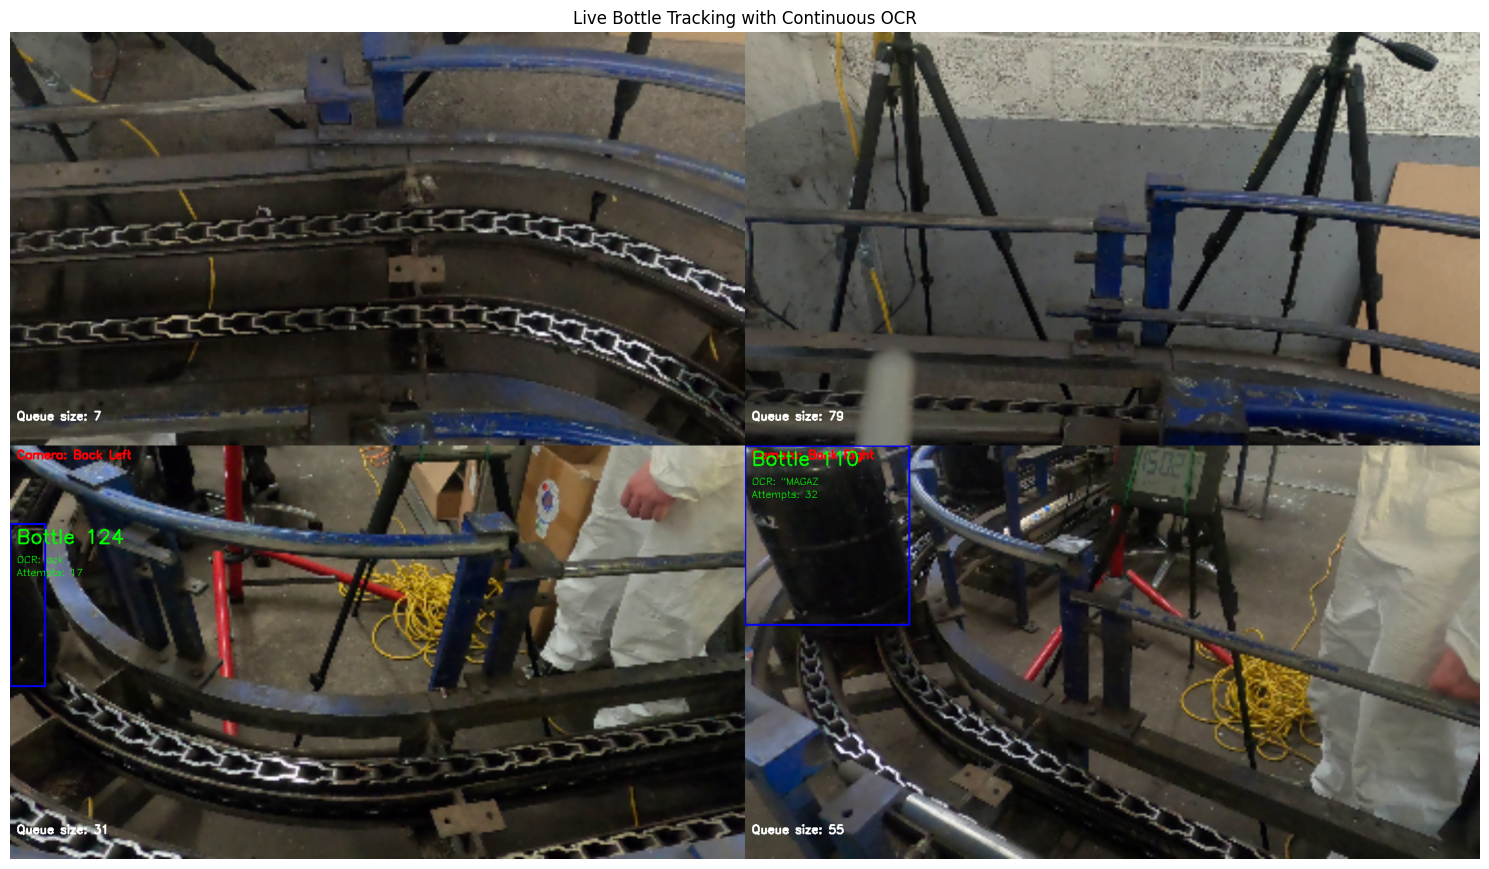

In [ ]:
run_tracking()

In [ ]:
import pandas as pd
import re
from collections import Counter

df = pd.read_csv("bottle_ocr_results.csv")
df["ocr_text"] = df["ocr_text"].astype(str)

# Keep same filtering as before
filter_pattern = r"(KG|KG-\d{4}|\d{2}\.\d)"
filtered_df = df[df["ocr_text"].str.contains(filter_pattern, regex=True, na=False)]

# Patterns
tarra_pattern = r"(\d{2}\.\d(?:\s?KG)?)"
year_pattern = r"(KG-\d{4}|\d{4})"

results = []

def normalize_tarra(t):
    """Turn '10.7 KG' or '10.7KG' into '10.7'."""
    return re.sub(r"\s?KG", "", t)

def normalize_year(y):
    """Turn 'KG-2034' into '2034'."""
    return re.sub(r"KG-", "", y)

for bottle_id, group in filtered_df.groupby("bottle_id"):

    tarra_list = []
    year_list = []

    for text in group["ocr_text"]:
        matches = re.findall(tarra_pattern, text)
        for m in matches:
            tarra_list.append(normalize_tarra(m))

        ym = re.findall(year_pattern, text)
        for y in ym:
            y_norm = int(normalize_year(y))
            if y_norm >= 2000:   # only keep >= 2000
                year_list.append(str(y_norm))

    if tarra_list:
        tarra_counts = Counter(tarra_list)
        top_tarra = tarra_counts.most_common(1)[0][0]
    else:
        top_tarra = None

    if year_list:
        year_counts = Counter(year_list)
        top_year = year_counts.most_common(1)[0][0]
    else:
        top_year = None

    results.append({
        "bottle_id": bottle_id,
        "tarra": top_tarra,
        "year": top_year
    })

result_df = pd.DataFrame(results)
result_df.to_csv("bottle_ocr_filtered_results.csv", index=False)

print("Created bottle_ocr_filtered_results.csv successfully!")


Created bottle_ocr_filtered_results.csv successfully!


C:\Users\brech\AppData\Local\Temp\ipykernel_14572\177400053.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df = df[df["ocr_text"].str.contains(filter_pattern, regex=True, na=False)]
